### General rules:
 * Replace *Template* by your *FirstnameLastname* in the filename before submitting the solution.
 * For all figures that you generate, remember to add meaningful labels to the axes, and make a legend, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.

# AAND 2019 - BCI Exercise Sheet #01

#### Name: Leonard Hollander

In [1]:
# This is just a suggestion. You can do it your way.

import numpy as np
import scipy as sp
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import bci_minitoolbox as bci


#Adjusting matplotlib settings:

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams['axes.prop_cycle']= \
matplotlib.cycler(color=['tomato', 'steelblue', \
                        'coral','skyblue', 'silver',\
                        'gainsboro', 'whitesmoke'])

## Load the data set

In [2]:
fname= 'eyes_closed_VPal.npz'
X, fs, clab, mnt = bci.load_data(fname)
clab = np.array(clab) #clab to array

## Exercise 1: PCA on raw data  (2 points)
Make a scatter plot using the channels Fz and Oz. Visualize the complete covariance matrix (functions `np.cov` and `pl.imshow`). Then determine the two principle components (Eigenvectors) (function `np.linalg.eigh`) of that data that correspond to the largest Eigenvalues and display them as scalp maps (function `scalpmap` provided in the `bci_minitoolbox`).

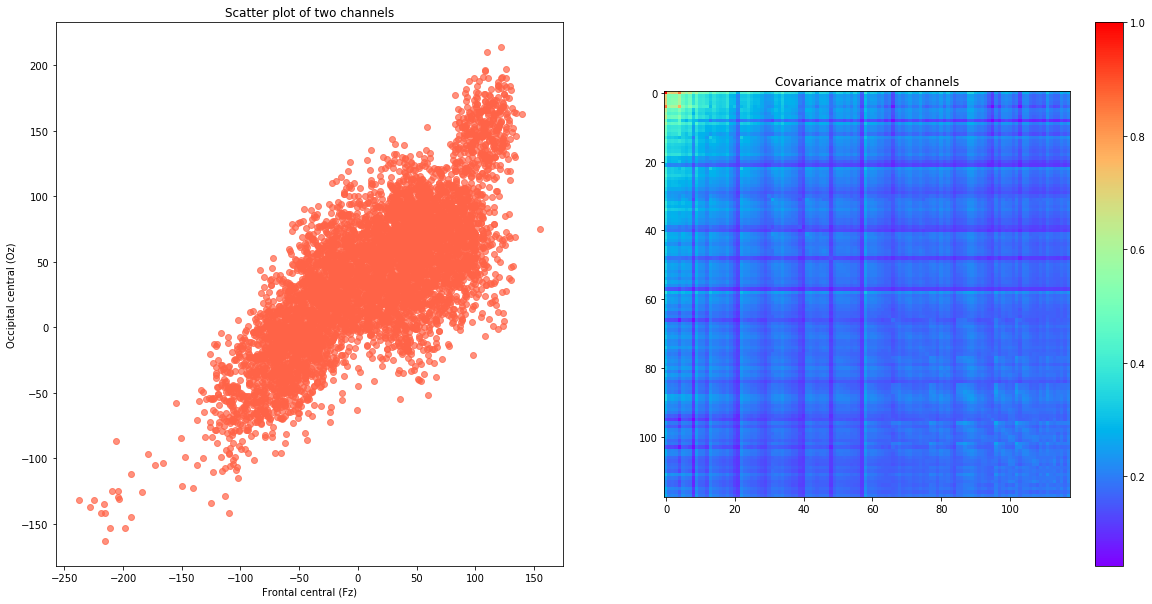

In [3]:
Fz, Oz = X[np.where(clab=='Fz')], X[np.where(clab=='Oz')]

#Make scatter plot and diplay the covariance matrix:

fig, axs = plt.subplots(1,2, figsize = (20,10))
axs[0].scatter(Fz,Oz, c='tomato', alpha=.7)
axs[0].set_xlabel('Frontal central (Fz)')
axs[0].set_ylabel('Occipital central (Oz)')
axs[0].set_title('Scatter plot of two channels')

im1 = axs[1].imshow(np.cov(X) / np.max(np.cov(X)), cmap='rainbow')
axs[1].set_title('Covariance matrix of channels')
plt.colorbar(im1, ax = axs[1])

#Solve the eigenvalue problem

def pca(data):
    
    #Solve the eigenvalue problem:
    
    evals, evecs = np.linalg.eigh(np.cov(data))
    
    #Since evecs is orthonormalbasis we have evecs.T = Inv(evecs):
    
    return evals, evecs

evals, evecs = pca(X)

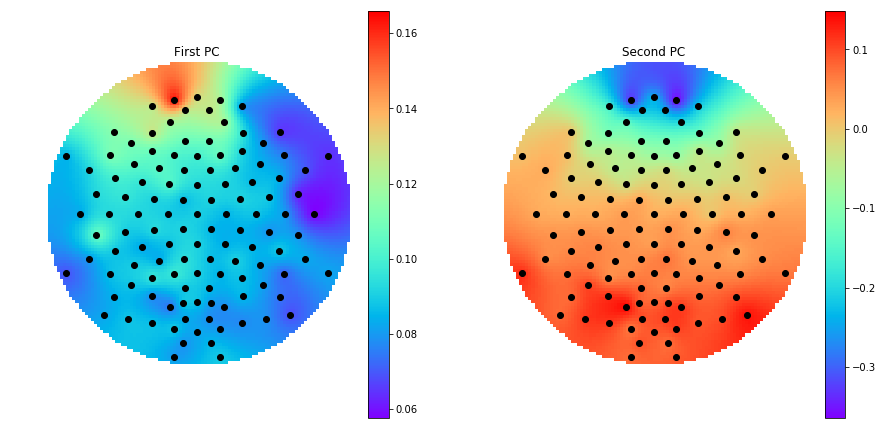

In [4]:
#Scalpmaps of the two PCs:
plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
bci.scalpmap(mnt, evecs.T[-1,:])
plt.title('First PC')

plt.subplot(1,2,2)
bci.scalpmap(mnt,evecs.T[-2,:])
plt.title('Second PC')
plt.show()


From the covariance matrix, we were led to surmise that the signal from the frontal areas is the most dominant. This is confirmed in these plots. The two PCs are parallel/anti-parallel (curiously, this dependance is flipped when we use np.linalg.eig instead of np.linalg.eigh) with the signal from the frontal areas.

## Exercise 2: Artifact Correction with PCA  (3 points)
Using the backward model, estimate the source activity corresponding to the two components that were found in Ex. \#01 and plot the two obtained time series. Using the forward model, estimate that part of the measured EEG signals, that originates from these two sources. Subtract this multivariate signal from the original EEG. Compare the thus obtained cleaned signal in channel Fz with the original data.

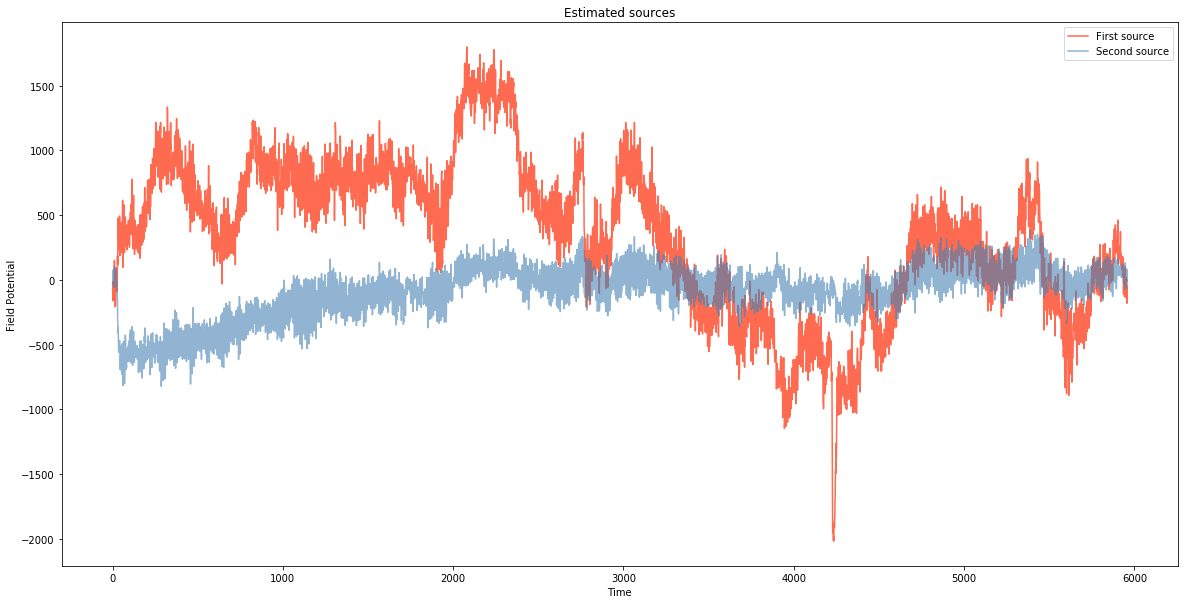

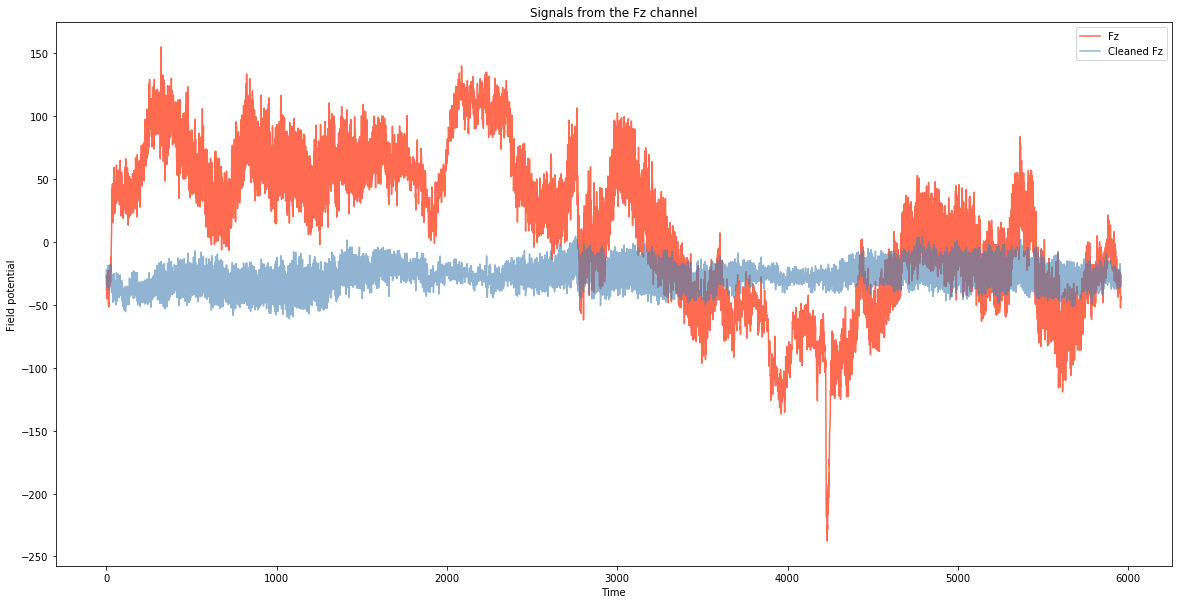

In [5]:
estimated_source = evecs.T[-2:,:] @ X
cleanedSignal = evecs.T[-2:,:].T @ estimated_source
cleanedSignal = X - cleanedSignal

plt.figure(figsize = (20,10))
plt.plot(estimated_source[1,:], alpha = .95, label = 'First source')
plt.plot(estimated_source[0,:], alpha = .6, label = 'Second source')
plt.title('Estimated sources')
plt.xlabel('Time')
plt.ylabel('Field Potential')
plt.legend()

plt.figure(figsize = (20,10))
plt.plot(np.arange(X.shape[1]), Fz.ravel(), alpha=.95, label = 'Fz')
plt.plot(np.arange(X.shape[1]), cleanedSignal[np.where(clab=='Fz')].ravel(), alpha = .6, label = 'Cleaned Fz')
plt.title('Signals from the Fz channel')
plt.xlabel('Time')
plt.ylabel('Field potential')
plt.legend()

The cleaned Signal appears to recover the Fz channel almost perfectly.

## Exercise 3: PCA on band-pass filtered data (3 points)
Design a butterworth band-pass filter of order 10 with the frequency band 8-12 Hz (function `sp.signal.butter`). Apply that band-pass filter to the original EEG signals (function `sp.signal.lfilter`) and compare raw and filtered signals for channel Oz.
Visualize the covariance matrix of the filtered data and check the eigenvalue spectrum, to determine how many strong principal components there are. Visualize those principal components as in Ex. \#01. Compare the results and discuss shortly.

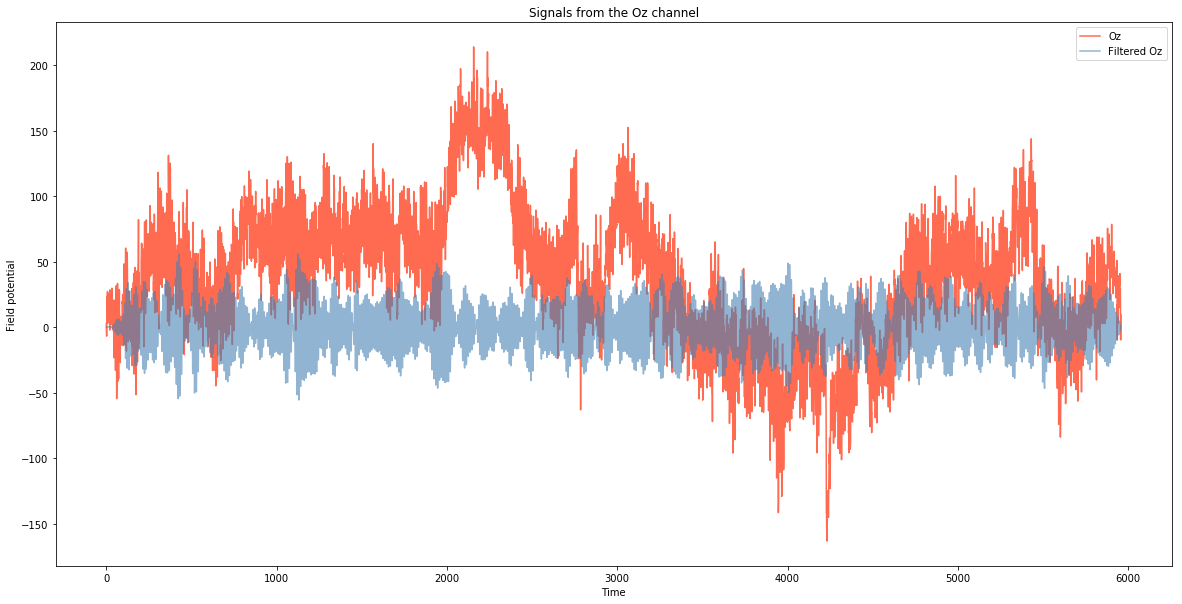

In [6]:
b, a = signal.butter(10, (16/fs, 24/fs), btype='bandpass')
filteredX = signal.lfilter(b,a,X)

#Plot results:
plt.figure(figsize=(20,10))
plt.plot(np.arange(X.shape[1]), Oz.ravel(), alpha=.95, label = 'Oz')
plt.plot(np.arange(X.shape[1]), filteredX[np.where(clab=='Oz')].ravel(), alpha = .6, label = 'Filtered Oz')
plt.title('Signals from the Oz channel')
plt.xlabel('Time')
plt.ylabel('Field potential')
plt.legend()

The filtered signal allows us to see that there is well defined potential oscillations in the respective frequency band.

(118, 5958)


Text(0, 0.5, 'Eigenvalue')

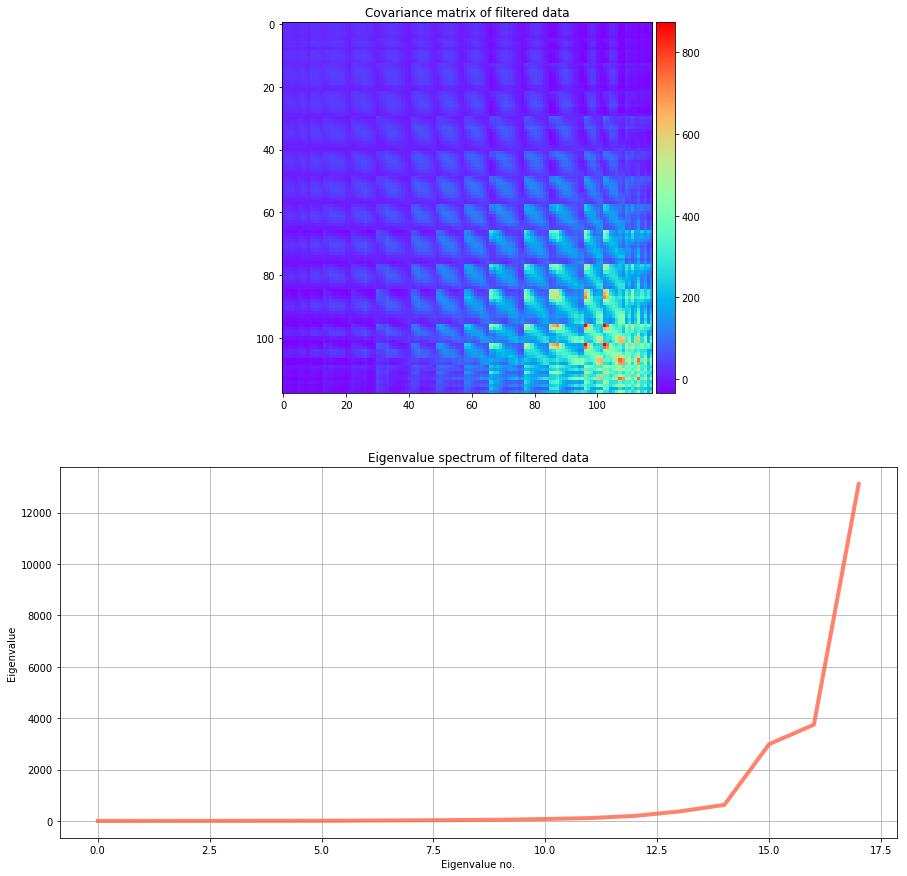

In [7]:
#Visualize the Covariance matrix of the filtered data:

print(filteredX.shape)

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(15,15))
im1 = ax0.imshow(np.cov(filteredX), cmap = 'rainbow')
ax0.set_title('Covariance matrix of filtered data')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax)

#Determine the spectrum of eigenvalues (make screeplot):
evalsF, evecsF = pca(filteredX) #get eigenvalues and eigenvectors
ax1.plot(np.arange(len(evalsF)-100), evalsF[100:], linewidth=4, alpha=.8, label='eigenvalues') #18 largest evals
ax1.grid()
ax1.set_title('Eigenvalue spectrum of filtered data')
ax1.set_xlabel('Eigenvalue no.')
ax1.set_ylabel('Eigenvalue')

So, within the frequency spectrum defined by the filter, the detectors with the highest indeces seem to send the strongest signals. Also from the Screeplot below we can see that about three main components (with to minor components). We'll now visualize those components. 

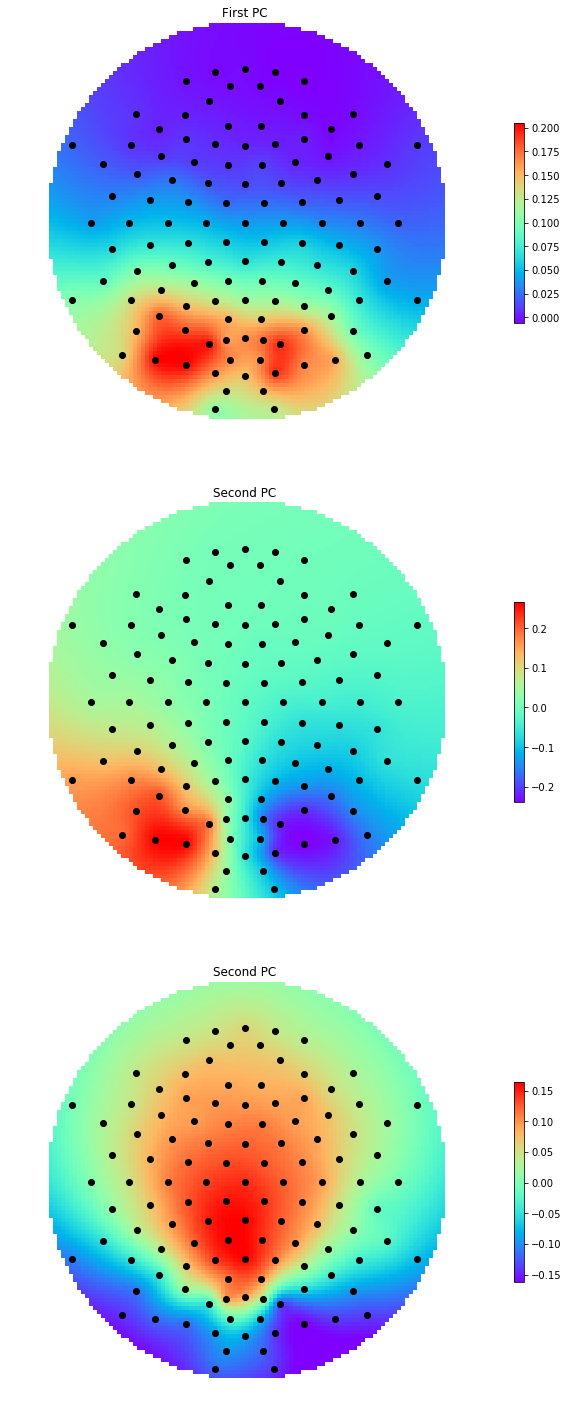

In [8]:
#Visualize the principal components:

plt.figure(figsize=(25,25))

plt.subplot(3,1,1)
bci.scalpmap(mnt, evecsF.T[-1,:])
plt.title('First PC')

plt.subplot(3,1,2)
bci.scalpmap(mnt,evecsF.T[-2,:])
plt.title('Second PC')

plt.subplot(3,1,3)
bci.scalpmap(mnt,evecsF.T[-3,:])
plt.title('Second PC')
plt.show()



So the in the frequency domain (8-12 Hz) that we are interested in, the strongest signals are those coming from occipital areas of the brain. In the earlier, unfiltered, case the strongest signals were those coming from the frontal sources. 

## Exercise 4: Reconstruction with few PCs  (2 points)
Calculate the signals corresponding to the strongest principal components (second part of Ex. \#03) of the filtered data (project EEG data onto the PCs, i.e. go from *sensor space* to *source space*). Then reconstruct the EEG data from those strong principal components, i.e. project the signals obtained in the first step back into *sensor space*. Compare the band-pass filtered signal with the reconstructed signal in channel Oz. For plotting, the first six seconds are enough. You can also apply an error measure on your choice.

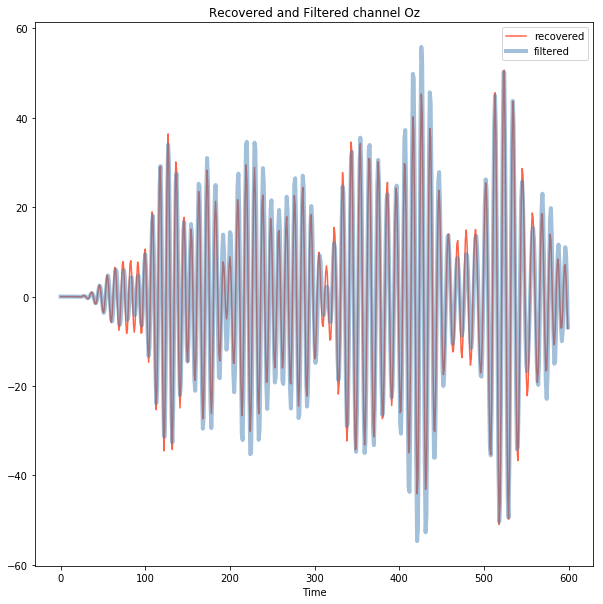

In [16]:
projectedSignals = evecsF[:,-3:].T @ filteredX #project EEG data onto the PCS of filtered data
recoveredSignals = evecsF[:,-3:] @ projectedSignals #project back into sensor space
recoveredOz = recoveredSignals[np.where(clab=='Oz')][:,:600].ravel() #first 600 seconds
filterOz = filteredX[np.where(clab=='Oz')][:,:600].ravel() #first 600 seconds

plt.figure(figsize=(10,10))
plt.plot(np.arange(600), recoveredOz, label='recovered')
plt.plot(np.arange(600), filterOz, linewidth=4, alpha=.5, label='filtered')
plt.title('Recovered and Filtered channel Oz')
plt.xlabel('Time')
plt.legend()

As expected, the filtered and recovered data overlap pretty neatly. We could have expected this given the shape of the eigenvectors we computed in Part 3.